In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
features = [
    "sym_Jet0_pt", "sym_Jet1_pt", "sym_Jet2_pt", "sym_Jet3_pt",
    "sym_Jet0_eta", "sym_Jet1_eta", "sym_Jet2_eta", "sym_Jet3_eta",
    "sym_Jet0_phi", "sym_Jet1_phi", "sym_Jet2_phi", "sym_Jet3_phi",  
    "sym_Jet0_m", "sym_Jet1_m", "sym_Jet2_m", "sym_Jet3_m",
]

0it [00:00, ?it/s]

successfully loaded {'experiment_name': 'fvt_training_n_samples_1', 'seed': 42, 'n_sample_ratio': 1.0}


1it [00:28, 28.02s/it]

n_sample_ratio=1.0


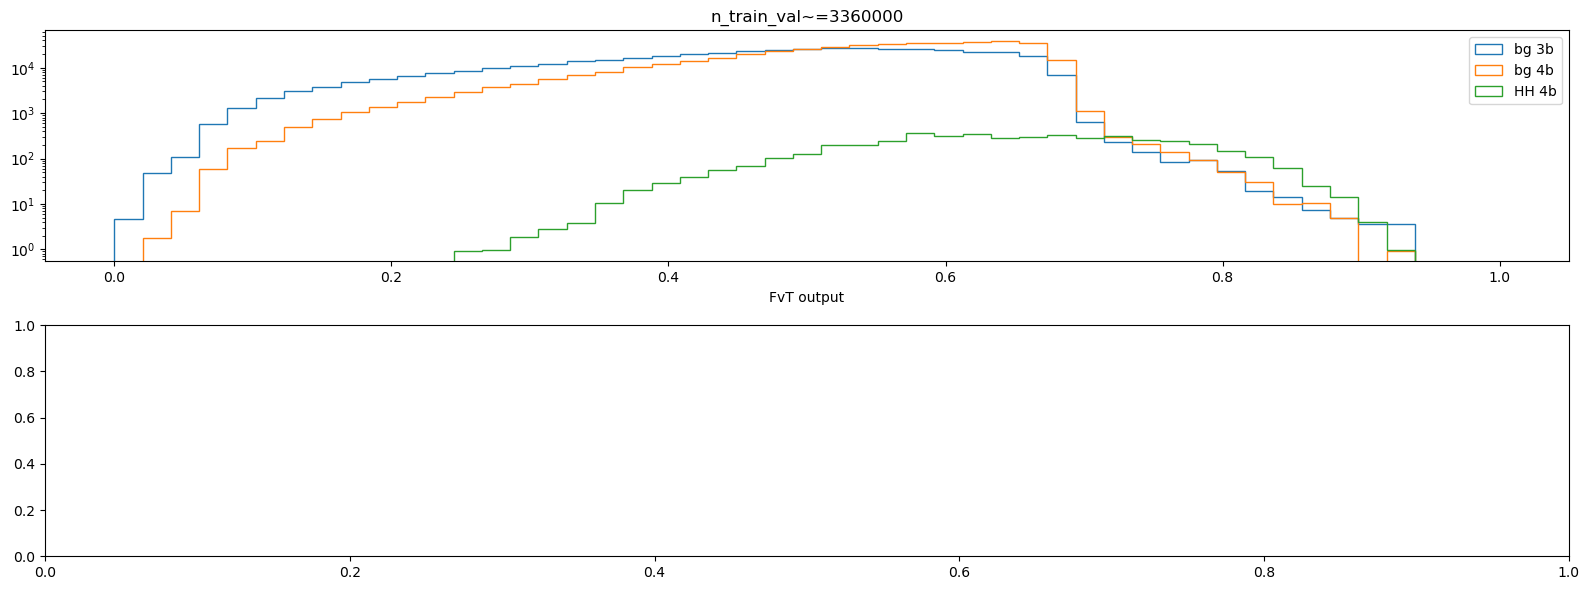

0it [00:00, ?it/s]

successfully loaded {'experiment_name': 'fvt_training_n_samples_1', 'seed': 52, 'n_sample_ratio': 1.0}


1it [00:06,  6.19s/it]

n_sample_ratio=1.0


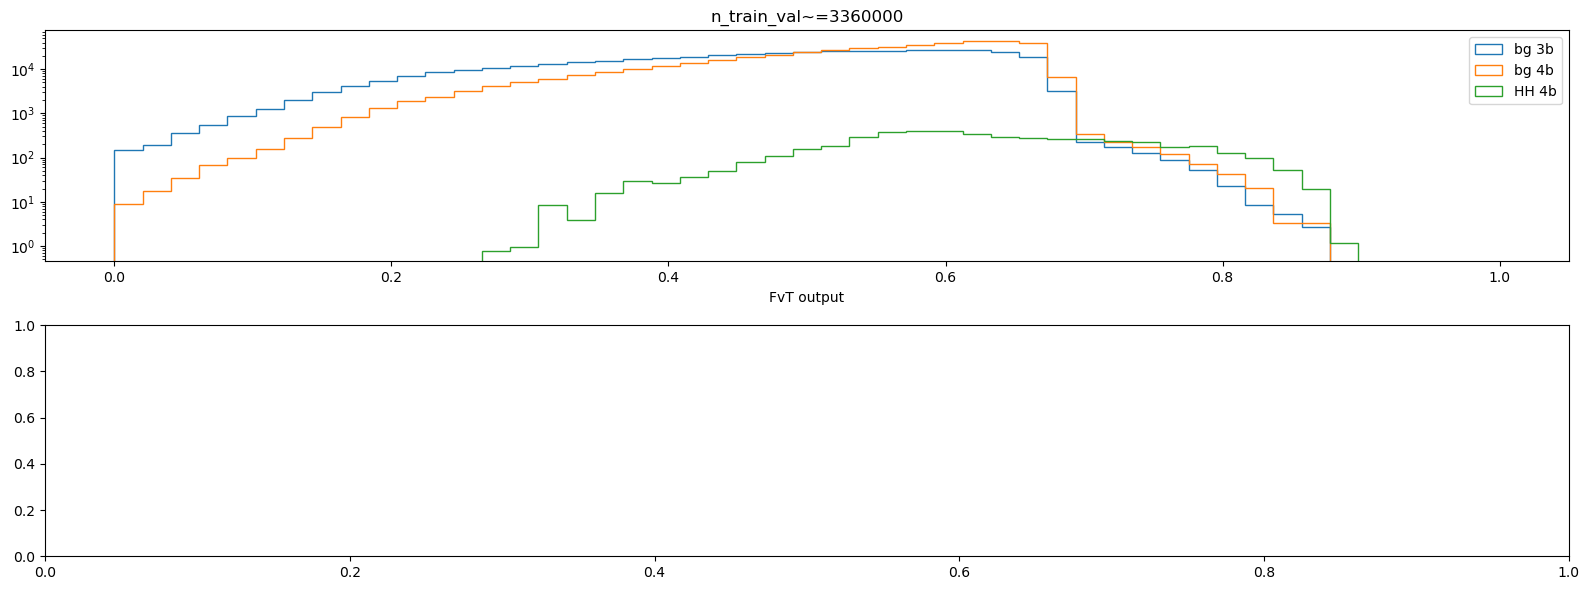

0it [00:00, ?it/s]

successfully loaded {'experiment_name': 'fvt_training_n_samples_1', 'seed': 62, 'n_sample_ratio': 1.0}


1it [00:06,  6.41s/it]

n_sample_ratio=1.0


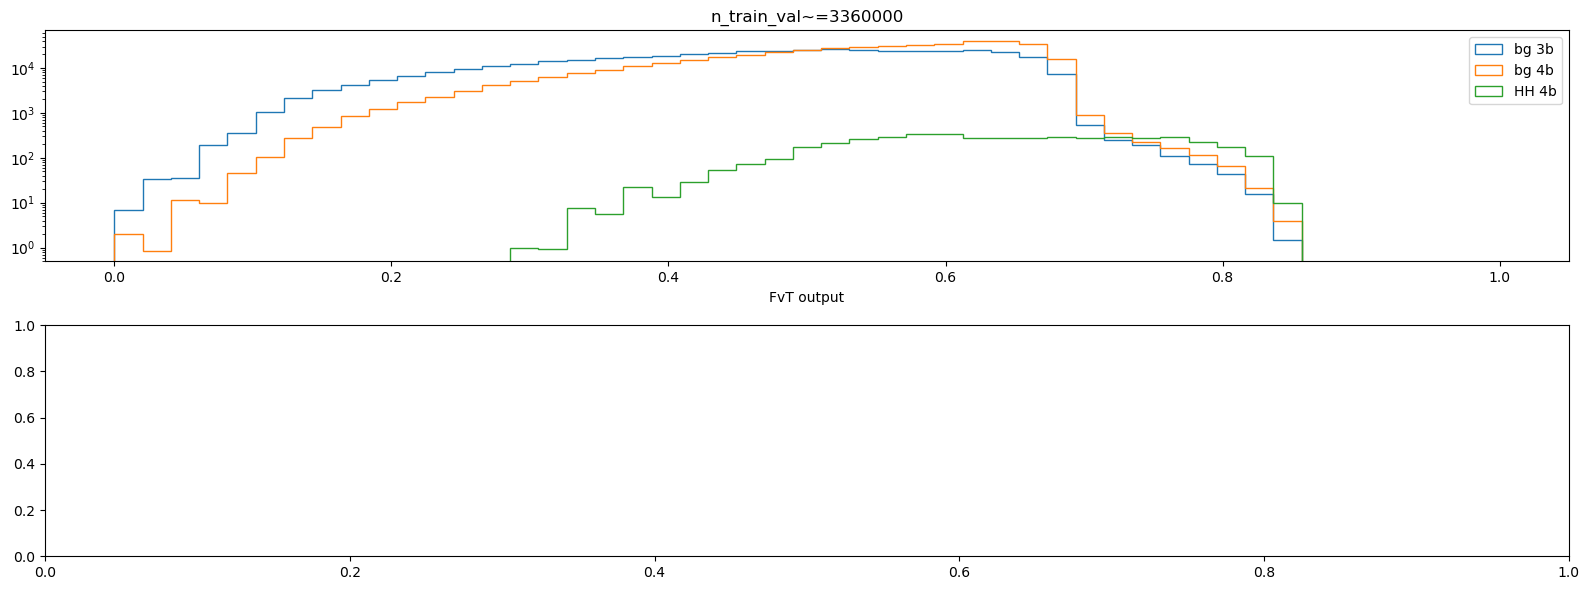

0it [00:00, ?it/s]

successfully loaded {'experiment_name': 'fvt_training_n_samples_1', 'seed': 72, 'n_sample_ratio': 1.0}


1it [00:06,  6.13s/it]

n_sample_ratio=1.0


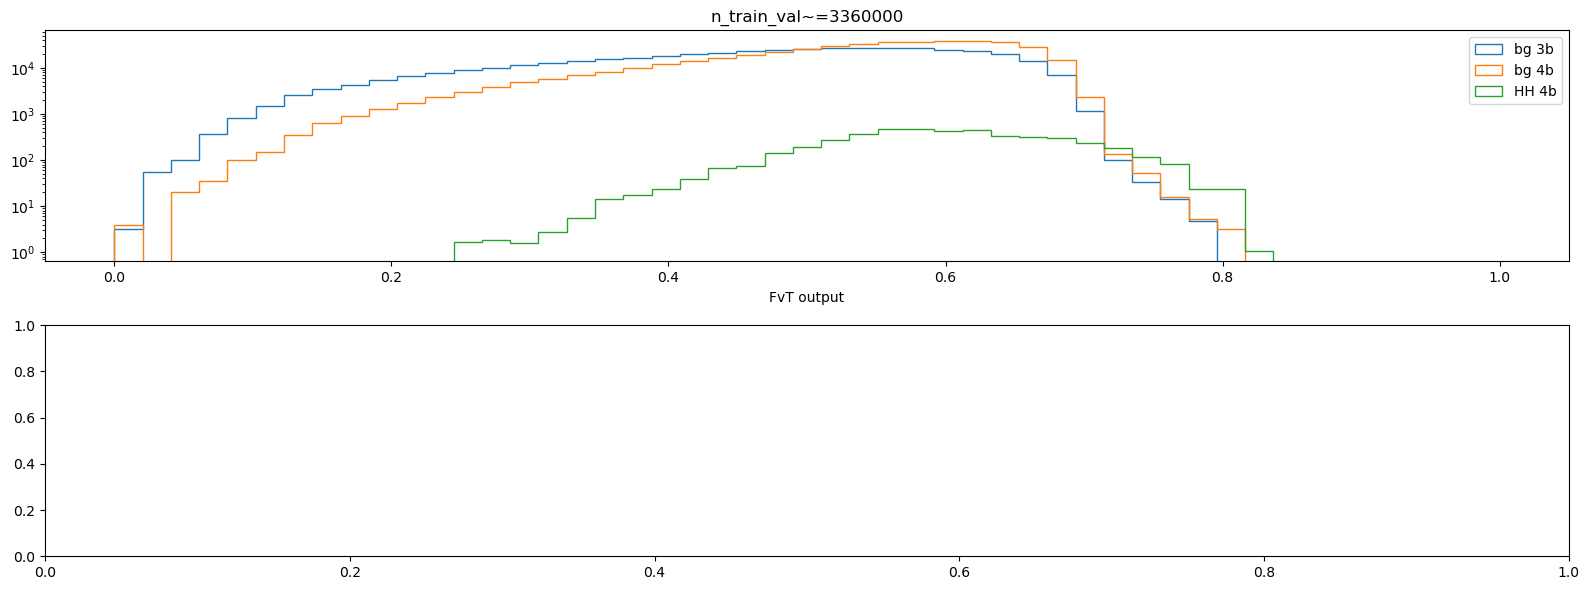

0it [00:00, ?it/s]

successfully loaded {'experiment_name': 'fvt_training_n_samples_1', 'seed': 82, 'n_sample_ratio': 1.0}


1it [00:06,  6.18s/it]

n_sample_ratio=1.0


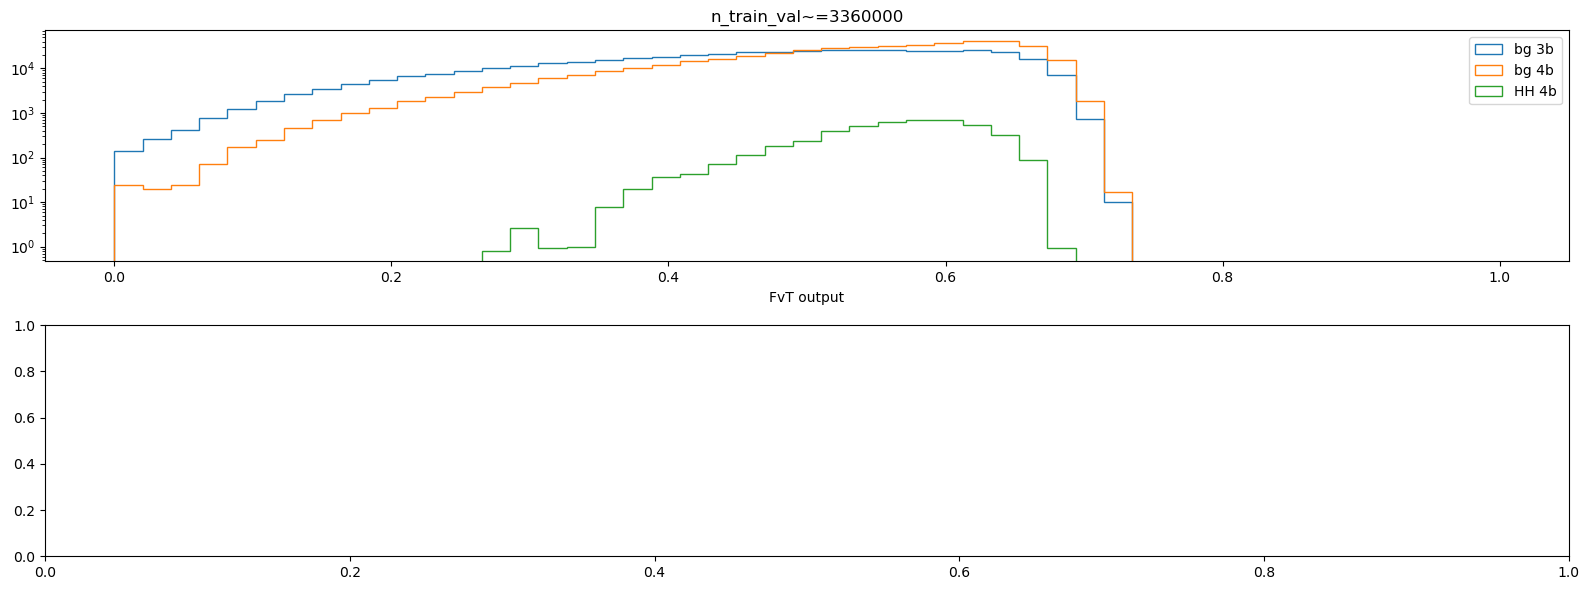

0it [00:00, ?it/s]

successfully loaded {'experiment_name': 'fvt_training_n_samples_1', 'seed': 92, 'n_sample_ratio': 1.0}


1it [00:06,  6.06s/it]

n_sample_ratio=1.0


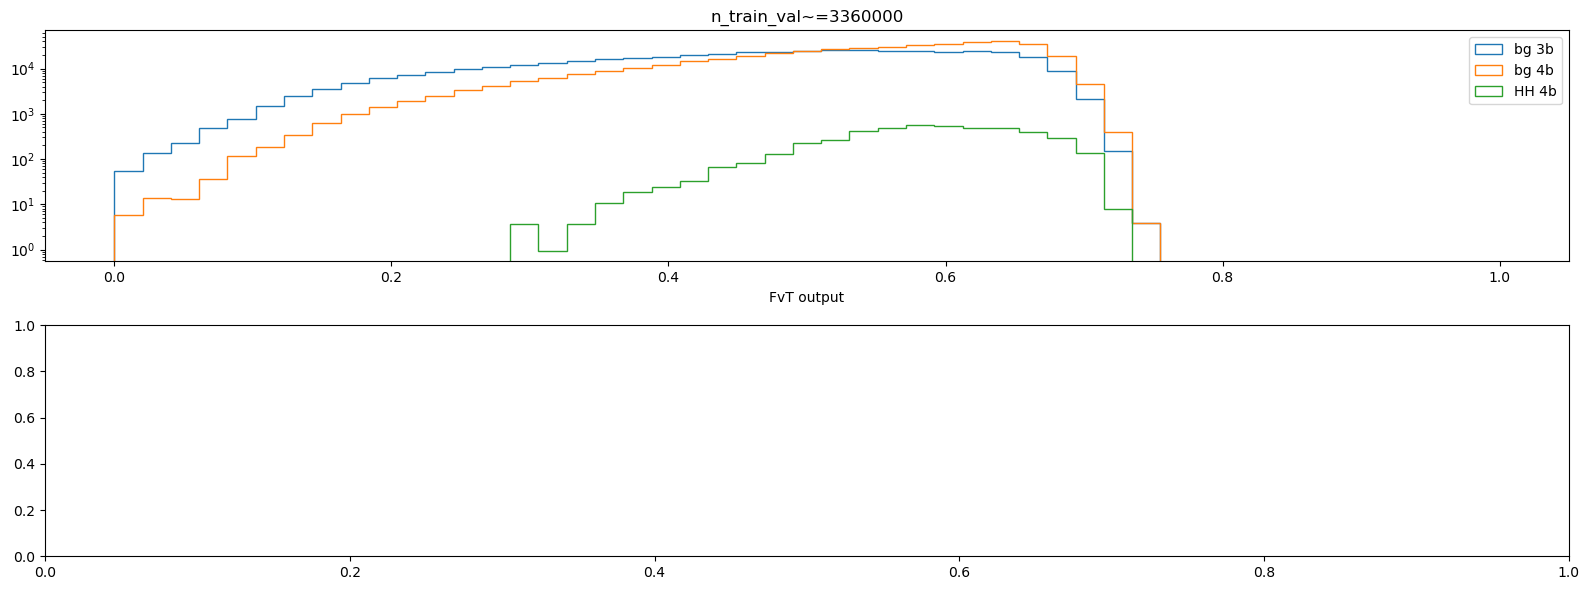

In [3]:
import torch
from dataset import generate_tt_dataset
from training_info import TrainingInfo
import pytorch_lightning as pl
import yaml
from fvt_classifier import FvTClassifier
from code_fragments import fvt_score_hist
from events_data import EventsData
import tqdm
import numpy as np
import matplotlib.pyplot as plt

config_filename = "configs/fvt_training_n_samples_1.yml"


config = yaml.safe_load(open(config_filename, "r"))
experiment_name = config["experiment_name"]
n_3b = config["n_3b"]
n_all4b = config["n_all4b"]
signal_ratio = config["signal_ratio"]
test_ratio = config["test_ratio"]
# n_sample_ratios = config["n_sample_ratios"]
n_sample_ratios = [1.0]
seeds = [42, 52, 62, 72, 82, 92]
w_cuts = np.arange(0.01, 1.01, 0.01)

fvt_scores_dict = {seed: {} for seed in seeds}
att_q_reprs_dict = {seed: {} for seed in seeds}
events_test_dict = {}
fvt_models_dict = {seed: {} for seed in seeds}

for seed in seeds:
    _, dinfo_test = generate_tt_dataset(
            seed,
            n_3b,
            n_all4b,
            signal_ratio,
            test_ratio,
        )
    events_test = EventsData.from_dataframe(dinfo_test.fetch_data(), features)
    events_test_dict[seed] = events_test

    nrows = 2
    ncols = int(np.ceil(len(n_sample_ratios) / 2))
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 6))

    for ax_cnt, n_sample_ratio in tqdm.tqdm(enumerate(n_sample_ratios)):
        hparam_filter = {"experiment_name": experiment_name, 
                         "seed": seed, 
                         "n_sample_ratio": n_sample_ratio}
        hashes = TrainingInfo.find(hparam_filter)
        assert len(hashes) == 1
        print("successfully loaded", hparam_filter)
        hash = hashes[0]
        tinfo = TrainingInfo.load(hash)
        fvt_model = FvTClassifier.load_from_checkpoint(f"./checkpoints/{hash}_best.ckpt")
        fvt_model.eval()

        current_ax = ax[ax_cnt // ncols, ax_cnt % ncols] if ncols > 1 else ax[ax_cnt]
        current_ax.set_title(f"n_train_val~={1000 * ((len(tinfo.dinfo_train) + len(tinfo.dinfo_val)) // 1000)}")
        device = torch.device("cuda:0")
        fvt_model = fvt_model.to(device)
        events_test.set_model_scores(fvt_model)
        fvt_score_hist(events_test, current_ax, logscale=True)
        
        print(f"n_sample_ratio={n_sample_ratio}")
        # att_q_repr_hist(events_test, title=f"n_sample_ratio={n_sample_ratio}")

        fvt_scores_dict[seed][n_sample_ratio] = events_test.fvt_score
        att_q_reprs_dict[seed][n_sample_ratio] = events_test.att_q_repr
        fvt_models_dict[seed][n_sample_ratio] = fvt_model

    fig.tight_layout()
    fig.show()

    plt.show()
    plt.close()

In [4]:
import logging
import tqdm
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)
logging.getLogger("lightning").setLevel(logging.WARNING)

n_sample_ratio = 1.0
device = torch.device("cuda:0")
noise_scales = [0.025, 0.05, 0.1, 0.2]
peak_pcts = [0.1**2, 0.05**2, 0.025**2]

In [5]:
def plot_sr_stats(events, sr_stats, ax, label, **plot_kwargs):
    assert len(events) == len(sr_stats)

    sr_stats_argsort = np.argsort(sr_stats)[::-1]
    weights = events.weights[sr_stats_argsort]
    is_signal = events.is_signal[sr_stats_argsort]
    is_4b = events.is_4b[sr_stats_argsort]

    ax.plot(
        np.cumsum(weights * is_4b) / np.sum(weights * is_4b),
        np.cumsum(weights * is_signal) / np.sum(weights * is_signal),           
        label=label,
        **plot_kwargs,
    )

/home/soheuny/miniconda3/envs/coffea_torch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


successfully loaded {'experiment_name': 'fvt_training_n_samples_1', 'seed': 42, 'n_sample_ratio': 1.0}


  0%|          | 0/4 [00:00<?, ?it/s]

noise_scale=0.025


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
 25%|██▌       | 1/4 [00:30<01:31, 30.63s/it]

noise_scale=0.05


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
 50%|█████     | 2/4 [01:09<01:10, 35.35s/it]

noise_scale=0.1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
 75%|███████▌  | 3/4 [01:47<00:36, 36.84s/it]

noise_scale=0.2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
  0%|          | 0/3 [00:00<?, ?it/s]

peak_pct=0.010000000000000002


 33%|███▎      | 1/3 [00:08<00:16,  8.11s/it]

peak_pct=0.0025000000000000005


 67%|██████▋   | 2/3 [00:14<00:07,  7.37s/it]

peak_pct=0.0006250000000000001


100%|██████████| 3/3 [00:21<00:00,  7.15s/it]


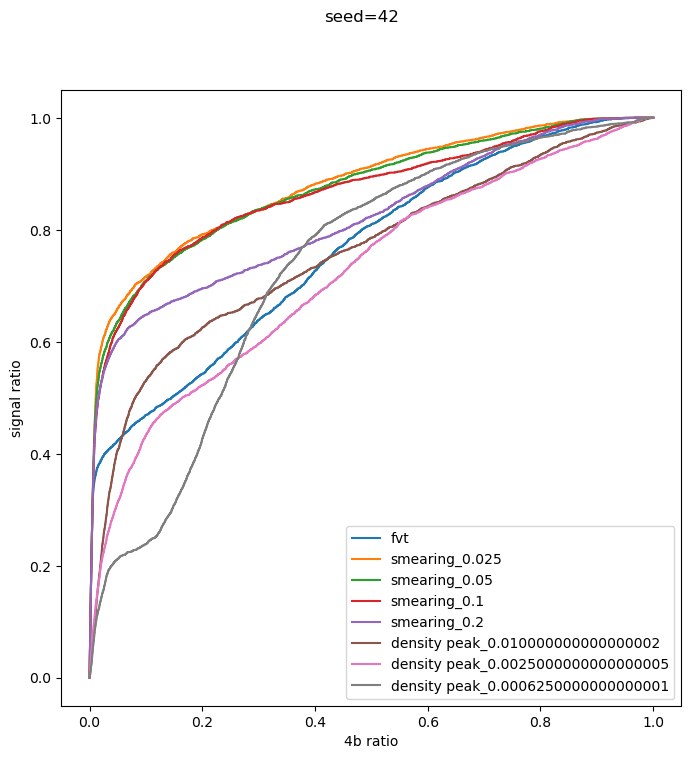

successfully loaded {'experiment_name': 'fvt_training_n_samples_1', 'seed': 52, 'n_sample_ratio': 1.0}


  0%|          | 0/4 [00:00<?, ?it/s]

noise_scale=0.025


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
 25%|██▌       | 1/4 [00:28<01:25, 28.34s/it]

noise_scale=0.05


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
 50%|█████     | 2/4 [00:56<00:56, 28.03s/it]

noise_scale=0.1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
 75%|███████▌  | 3/4 [01:24<00:27, 27.96s/it]

noise_scale=0.2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
  0%|          | 0/3 [00:00<?, ?it/s]

peak_pct=0.010000000000000002


 33%|███▎      | 1/3 [00:07<00:14,  7.08s/it]

peak_pct=0.0025000000000000005


 67%|██████▋   | 2/3 [00:13<00:06,  6.88s/it]

peak_pct=0.0006250000000000001


100%|██████████| 3/3 [00:20<00:00,  6.86s/it]


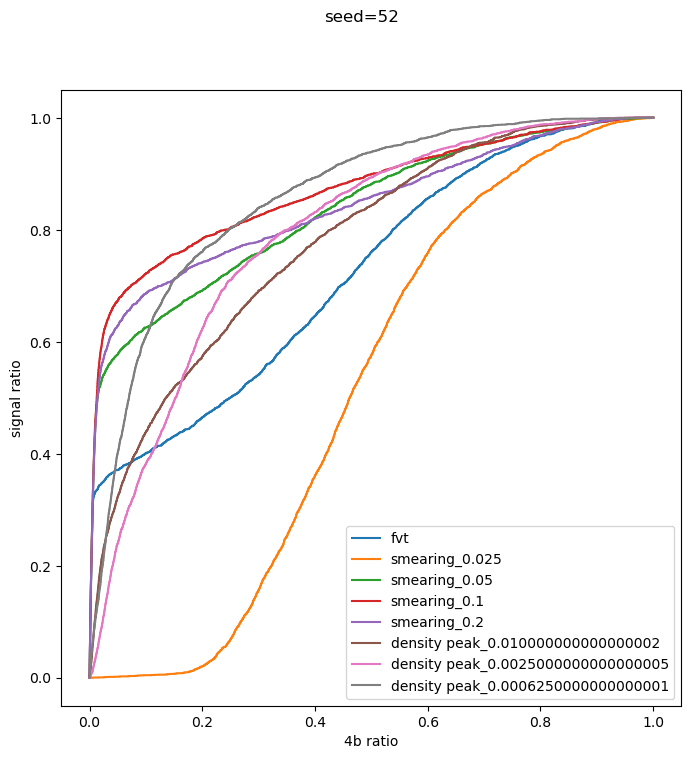

successfully loaded {'experiment_name': 'fvt_training_n_samples_1', 'seed': 62, 'n_sample_ratio': 1.0}


  0%|          | 0/4 [00:00<?, ?it/s]

noise_scale=0.025


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
 25%|██▌       | 1/4 [00:28<01:25, 28.35s/it]

noise_scale=0.05


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
 50%|█████     | 2/4 [01:01<01:01, 30.93s/it]

noise_scale=0.1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
 75%|███████▌  | 3/4 [01:34<00:31, 31.86s/it]

noise_scale=0.2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
  0%|          | 0/3 [00:00<?, ?it/s]

peak_pct=0.010000000000000002


 33%|███▎      | 1/3 [00:06<00:13,  6.99s/it]

peak_pct=0.0025000000000000005


 67%|██████▋   | 2/3 [00:13<00:06,  6.83s/it]

peak_pct=0.0006250000000000001


100%|██████████| 3/3 [00:20<00:00,  6.76s/it]


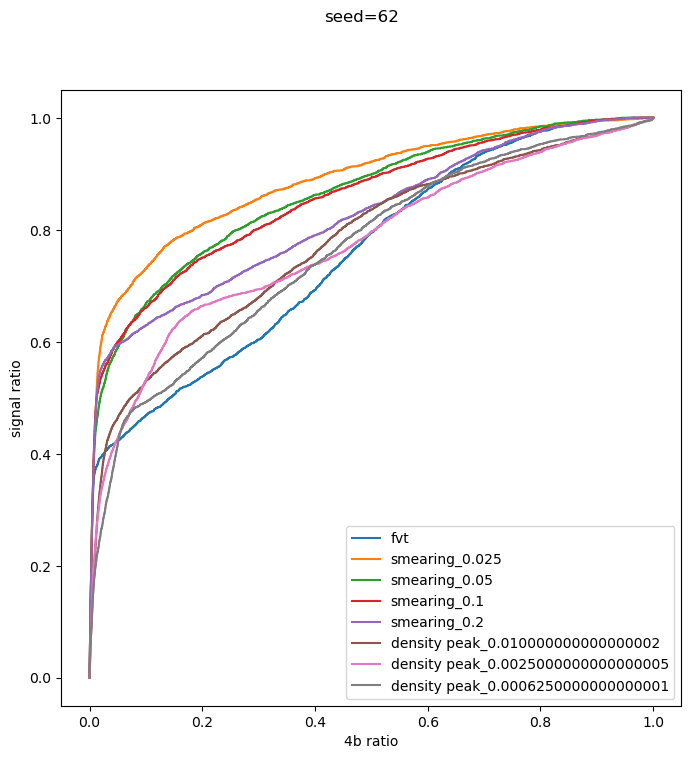

successfully loaded {'experiment_name': 'fvt_training_n_samples_1', 'seed': 72, 'n_sample_ratio': 1.0}


  0%|          | 0/4 [00:00<?, ?it/s]

noise_scale=0.025


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
 25%|██▌       | 1/4 [00:37<01:52, 37.34s/it]

noise_scale=0.05


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
 50%|█████     | 2/4 [01:05<01:04, 32.09s/it]

noise_scale=0.1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
 75%|███████▌  | 3/4 [01:34<00:30, 30.39s/it]

noise_scale=0.2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
  0%|          | 0/3 [00:00<?, ?it/s]

peak_pct=0.010000000000000002


 33%|███▎      | 1/3 [00:06<00:13,  6.98s/it]

peak_pct=0.0025000000000000005


 67%|██████▋   | 2/3 [00:13<00:06,  6.81s/it]

peak_pct=0.0006250000000000001


100%|██████████| 3/3 [00:20<00:00,  6.80s/it]


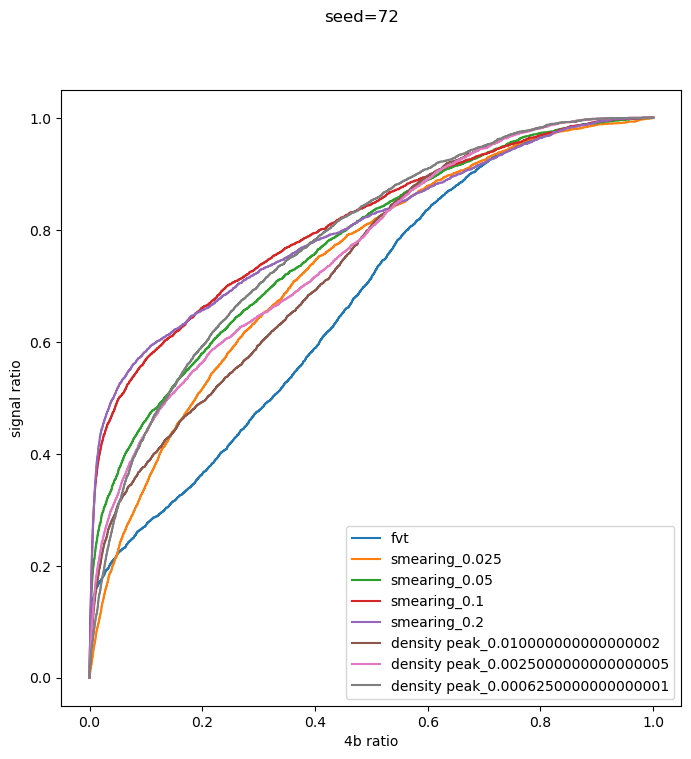

successfully loaded {'experiment_name': 'fvt_training_n_samples_1', 'seed': 82, 'n_sample_ratio': 1.0}


  0%|          | 0/4 [00:00<?, ?it/s]

noise_scale=0.025


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
 25%|██▌       | 1/4 [00:28<01:25, 28.61s/it]

noise_scale=0.05


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
 50%|█████     | 2/4 [00:56<00:56, 28.42s/it]

noise_scale=0.1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
 75%|███████▌  | 3/4 [01:25<00:28, 28.48s/it]

noise_scale=0.2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
  0%|          | 0/3 [00:00<?, ?it/s]

peak_pct=0.010000000000000002


 33%|███▎      | 1/3 [00:07<00:14,  7.18s/it]

peak_pct=0.0025000000000000005


 67%|██████▋   | 2/3 [00:13<00:06,  6.92s/it]

peak_pct=0.0006250000000000001


100%|██████████| 3/3 [00:20<00:00,  6.87s/it]


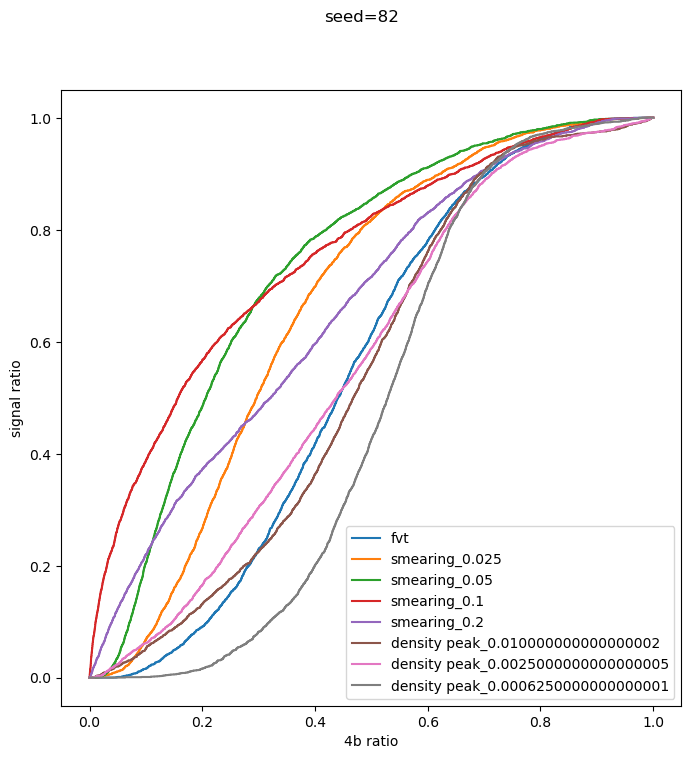

successfully loaded {'experiment_name': 'fvt_training_n_samples_1', 'seed': 92, 'n_sample_ratio': 1.0}


  0%|          | 0/4 [00:00<?, ?it/s]

noise_scale=0.025


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
 25%|██▌       | 1/4 [00:32<01:38, 32.83s/it]

noise_scale=0.05


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
 50%|█████     | 2/4 [01:01<01:00, 30.15s/it]

noise_scale=0.1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
 75%|███████▌  | 3/4 [01:29<00:29, 29.42s/it]

noise_scale=0.2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
  0%|          | 0/3 [00:00<?, ?it/s]

peak_pct=0.010000000000000002


 33%|███▎      | 1/3 [00:07<00:14,  7.12s/it]

peak_pct=0.0025000000000000005


 67%|██████▋   | 2/3 [00:13<00:06,  6.90s/it]

peak_pct=0.0006250000000000001


100%|██████████| 3/3 [00:20<00:00,  6.81s/it]


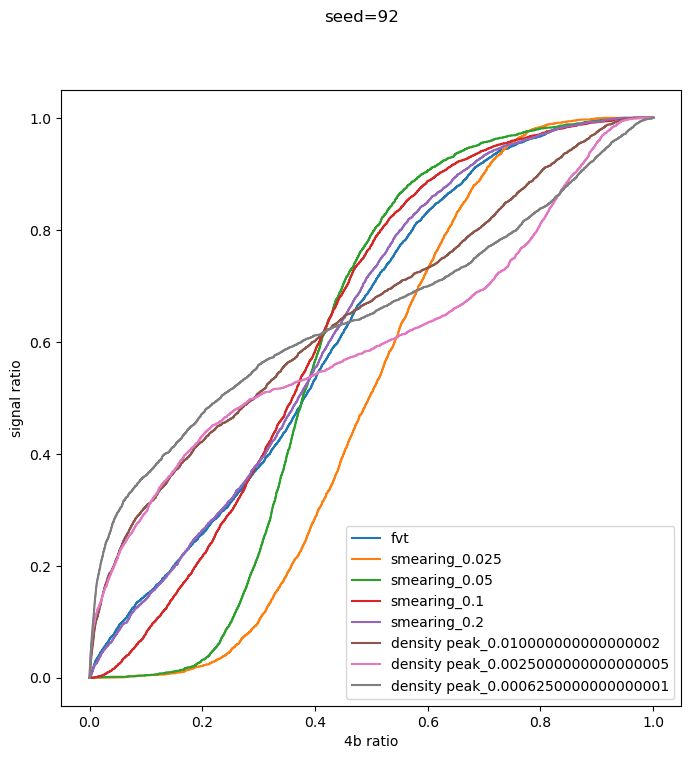

In [6]:
from signal_region import get_regions_stats
from copy import deepcopy

signal_region_stats_dict = {}
for seed in seeds:
    hparam_filter = {"experiment_name": experiment_name, 
                    "seed": seed, 
                    "n_sample_ratio": n_sample_ratio}
    hashes = TrainingInfo.find(hparam_filter)
    assert len(hashes) == 1
    print("successfully loaded", hparam_filter)
    fvt_hash = hashes[0]

    events_sr_train, events_sr_eval = events_test_dict[seed].split(1/3, seed=seed)

    signal_region_stats_dict_inner = {
        "fvt": None,
        "density_peak": {peak_pct: None for peak_pct in peak_pcts},
        "smearing": {noise_scale: None for noise_scale in noise_scales},
    }

    signal_region_stats_dict_inner["fvt"] = get_regions_stats(
        events_sr_eval, fvt_hash, method="fvt")

    for noise_scale in tqdm.tqdm(noise_scales):
        print(f"noise_scale={noise_scale}")
        signal_region_stats_dict_inner["smearing"][noise_scale] = get_regions_stats(
            events_sr_eval, fvt_hash, method="smearing", 
            events_sr_train=events_sr_train, noise_scale=noise_scale)
        
    for peak_pct in tqdm.tqdm(peak_pcts):
        print(f"peak_pct={peak_pct}")
        signal_region_stats_dict_inner["density_peak"][peak_pct] = get_regions_stats(
            events_sr_eval, fvt_hash, method="density_peak", 
            events_sr_train=events_sr_train, peak_pct=peak_pct)
        
    fig, ax = plt.subplots(figsize=(8, 8))
    fig.suptitle(f"seed={seed}")
    plot_sr_stats(events_sr_eval, signal_region_stats_dict_inner["fvt"], ax, "fvt")
    for noise_scale in noise_scales:
        plot_sr_stats(events_sr_eval, signal_region_stats_dict_inner["smearing"][noise_scale], ax, f"smearing_{noise_scale}")

    for peak_pct in peak_pcts:
        plot_sr_stats(events_sr_eval, signal_region_stats_dict_inner["density_peak"][peak_pct], ax, f"density peak_{peak_pct}")

    ax.set_xlabel("4b ratio")
    ax.set_ylabel("signal ratio")
    ax.legend()
    plt.show()
    plt.close()

    signal_region_stats_dict[seed] = deepcopy(signal_region_stats_dict_inner)

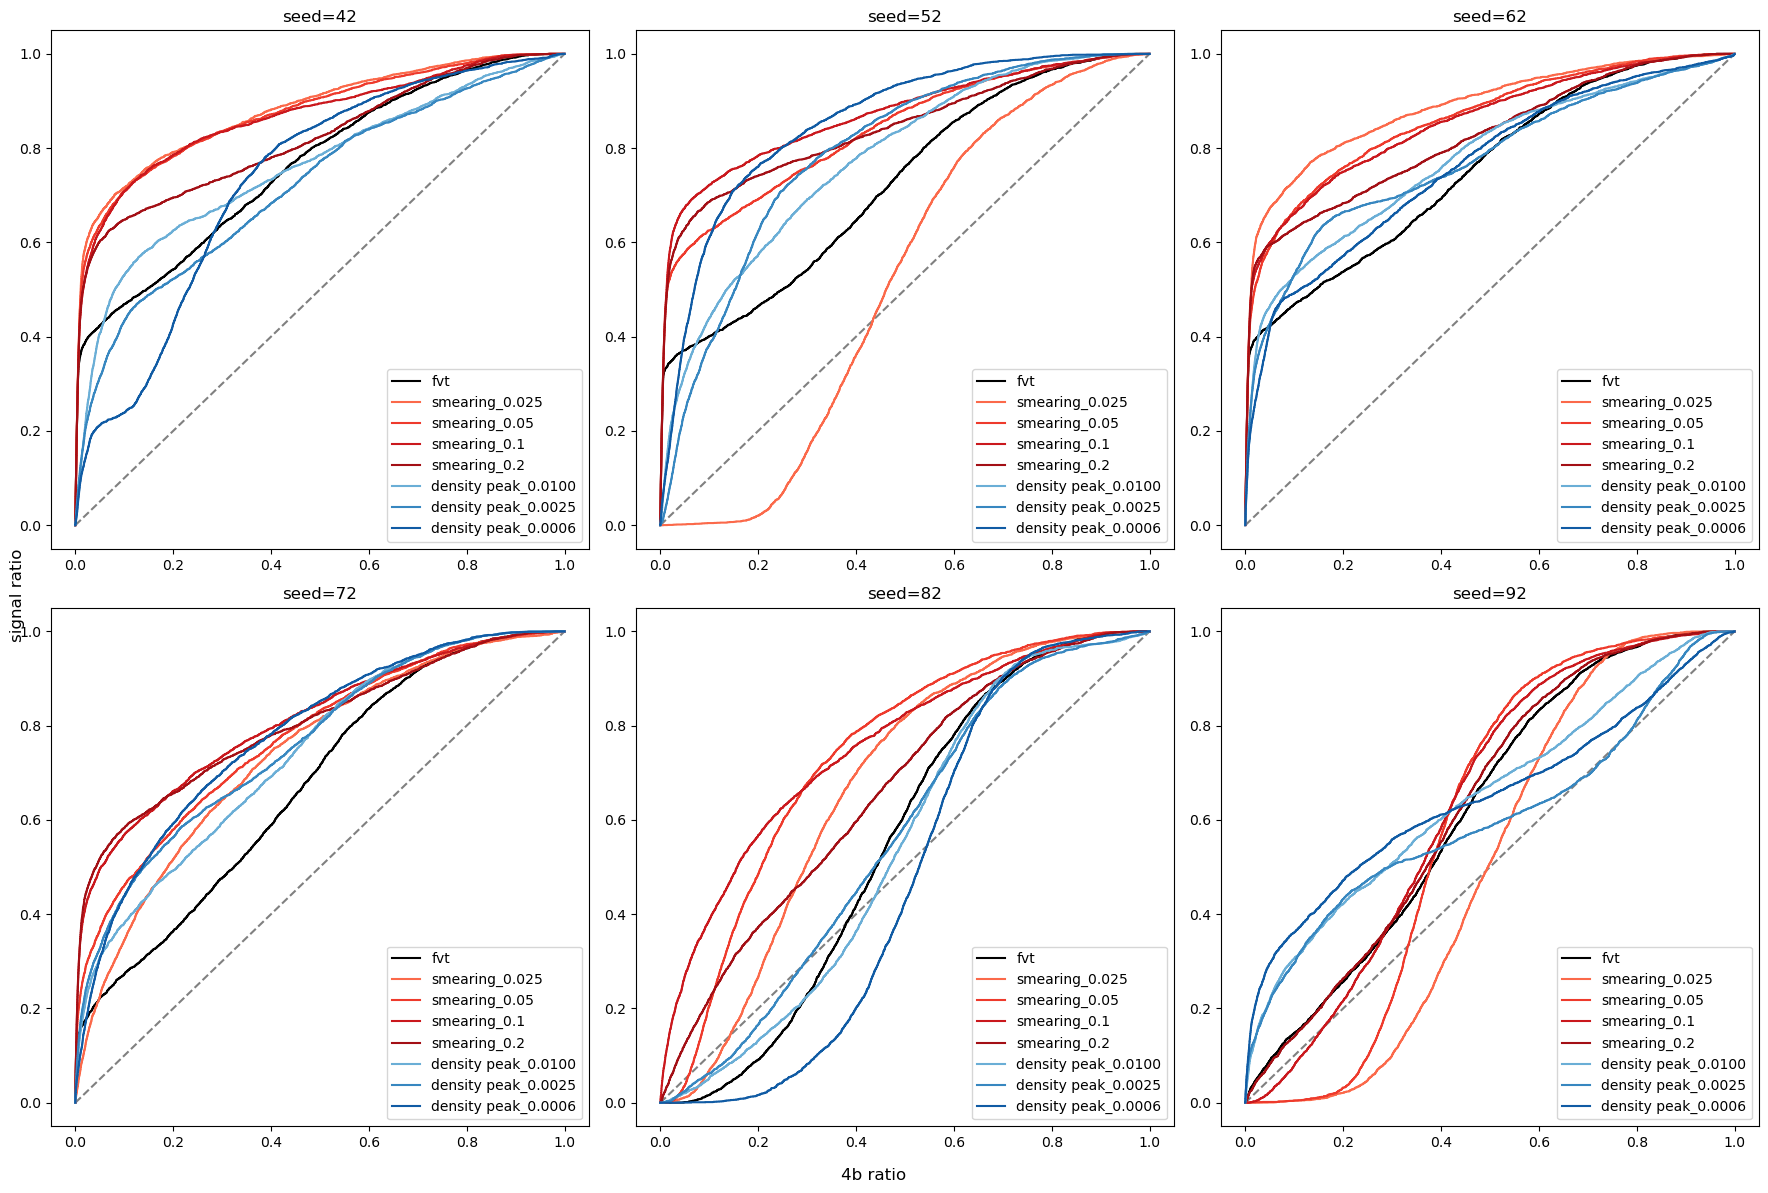

In [11]:
import matplotlib

def plot_sr_stats(events, sr_stats, ax, label, **plot_kwargs):
    assert len(events) == len(sr_stats)

    sr_stats_argsort = np.argsort(sr_stats)[::-1]
    weights = events.weights[sr_stats_argsort]
    is_signal = events.is_signal[sr_stats_argsort]
    is_4b = events.is_4b[sr_stats_argsort]

    ax.plot(
        np.cumsum(weights * is_4b) / np.sum(weights * is_4b),
        np.cumsum(weights * is_signal) / np.sum(weights * is_signal),           
        label=label,
        **plot_kwargs,
    )

nrows = 2
ncols = int(np.ceil(len(seeds) / 2))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 6*nrows))
fig.supxlabel("4b ratio")
fig.supylabel("signal ratio")

for ax_cnt, seed in enumerate(seeds):
    current_ax = ax[ax_cnt // ncols, ax_cnt % ncols] if ncols > 1 else ax[ax_cnt]
    _, events_sr_eval = events_test_dict[seed].split(1/3, seed=seed)

    current_ax.set_title(f"seed={seed}")
    current_ax.plot([0, 1], [0, 1], color="gray", linestyle="--")
    signal_region_stats = signal_region_stats_dict[seed]

    
    plot_sr_stats(events_sr_eval, signal_region_stats["fvt"], current_ax, "fvt", color="black")
    for color_i, noise_scale in enumerate(noise_scales):
        color = matplotlib.colormaps.get_cmap("Reds")((color_i / len(noise_scales)) / 2 + 0.5)
        plot_sr_stats(events_sr_eval, signal_region_stats["smearing"][noise_scale], current_ax, f"smearing_{noise_scale}", color=color)

    for color_i, peak_pct in enumerate(peak_pcts):
        color = matplotlib.colormaps.get_cmap("Blues")((color_i / len(peak_pcts)) / 2 + 0.5)
        plot_sr_stats(events_sr_eval, signal_region_stats["density_peak"][peak_pct], current_ax, "density peak_{:.4f}".format(peak_pct), color=color)

    current_ax.legend(loc="lower right")

fig.tight_layout()
fig.show()          
plt.show()

